## Loading and preprocessing ISTAT data

Processing pipeline to collect Istat cpa 2011 data for selected cities from downloaded data dump.

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from os import path, listdir
import shapely

In [2]:
## TODO: find way to put this into some global settings
import os
import sys
# go up two levels in path
nb_dir = os.path.dirname(os.path.dirname(os.getcwd()))
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

from references import common_cfg
sect_name_col = common_cfg.sezione_col_name

In [3]:
## Loading ISTAT data
data_dict = {}
for filename in common_cfg.get_istat_filelist():
    regionData = pd.read_csv(
        path.join(common_cfg.cpa_path, filename), sep=';', encoding='latin').set_index('SEZ2011')
    # extract the councils we are intersted in
    for city in common_cfg.city_list:
        cityData = regionData[regionData.COMUNE==city]
        if cityData.size>0:
            data_dict[city] = cityData
            
# export as csv to final folder for every city
for city, cityData in data_dict.items():
    pass
    #cityData.to_csv('../../data/processed/istat_cpa_2011/' + city + '_cpa_2011.csv', sep=';')

### Process ISTAT data for Bari to assign a quartiere label to each sezione

In [4]:
city_name = 'Bari'
shapedatapuglia = gpd.read_file('../../data/raw/Bari_specific/reg_puglia_sez')
shapedatapuglia = shapedatapuglia.to_crs({'init':'epsg:4326'})
shapedatapuglia.PRO_COM = shapedatapuglia.PRO_COM.astype(int)

In [5]:
shape_sez_bari = shapedatapuglia[shapedatapuglia.PRO_COM == 72006].reset_index(drop=True)

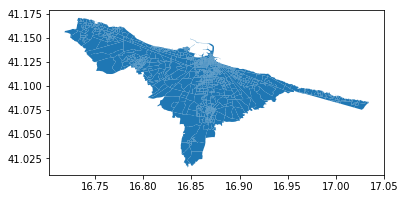

In [6]:
shape_sez_bari.plot()

In [32]:
city_name = 'Bari'
# These aren't exactly equal to 1, need to check mismatches in joining
print(shape_sez_bari[sect_name_col].isin(data_dict[city_name].index).mean())
print(data_dict[city_name].index.isin(shape_sez_bari[sect_name_col]).mean())

sezioni_data = pd.merge(shape_sez_bari, data_dict[city_name], how='inner',
                      right_index=True, left_on=common_cfg.sezione_col_name)
# Cast as int
sezioni_data[sect_name_col] = sezioni_data[sect_name_col].astype(float)

0.966688874083944
1.0


In [34]:
# append centroid value and use it to do the spatial join
save_polygon = sezioni_data['geometry'].copy()
sezioni_data['geometry'] = sezioni_data.geometry.centroid

quartieri_data = gpd.read_file('../../data/raw/Bari_specific/Bari_quartieri.geojson')
quartieri_data.rename({'id':common_cfg.id_quartiere_col_name,
                       'nome': common_cfg.quartiere_desc_col_name},
                        axis=1, inplace=True)

joined_bari = gpd.sjoin(
    sezioni_data, quartieri_data, how="left", op='within')

# restore full geometry
joined_bari['geometry'] = save_polygon

# check missing values
print(sum(joined_bari[common_cfg.id_quartiere_col_name].isnull()))

79


In [35]:
joined_bari = joined_bari[~joined_bari[common_cfg.id_quartiere_col_name].isnull()]
joined_bari[common_cfg.id_quartiere_col_name] = joined_bari[
    common_cfg.id_quartiere_col_name].astype(int)

In [37]:
out_bari_filename = '../../data/processed/Bari_sezioni.geojson'
joined_bari.to_file(out_bari_filename, driver='GeoJSON')

In [38]:
# check loading
print(gpd.read_file(out_bari_filename))

      COD_REG   COD_ISTAT  PRO_COM       SEZ2011     SEZ  COD_STAGNO  \
0        16.0  16072006.0    72006  7.200600e+11   914.0         0.0   
1        16.0  16072006.0    72006  7.200600e+11   854.0         0.0   
2        16.0  16072006.0    72006  7.200600e+11   898.0         0.0   
3        16.0  16072006.0    72006  7.200600e+11   983.0         0.0   
4        16.0  16072006.0    72006  7.200600e+11   874.0         0.0   
5        16.0  16072006.0    72006  7.200600e+11  1131.0         0.0   
6        16.0  16072006.0    72006  7.200600e+11  1009.0         0.0   
7        16.0  16072006.0    72006  7.200600e+11   817.0         0.0   
8        16.0  16072006.0    72006  7.200600e+11  1142.0         0.0   
9        16.0  16072006.0    72006  7.200600e+11  1136.0         0.0   
10       16.0  16072006.0    72006  7.200600e+11   815.0         0.0   
11       16.0  16072006.0    72006  7.200600e+11  1135.0         0.0   
12       16.0  16072006.0    72006  7.200600e+11  1101.0        

### Process ISTAT data for Turin to assign a circoscrizione label and a "former neighbourhood" to each sezione

Data for "Circoscrizioni", "Quartieri" and "Zone statistiche" are already stored in DAF under "comune_torino_csi". 

They are private, in the future we can get data using API.

In [ ]:
#city
selected_city = "Torino"
#prefix for ISTAT SEZ2011
prefix_torino = 12720000000

# load name-id table for circoscrizioni, quartieri and sezioni censimento
circoscrizioniData = gpd.read_file('../../data/raw/Torino_specific/circoscrizioni_wgs84.geojson')

sezioniData = gpd.read_file ('../../data/raw/Torino_specific/sezioni_censimento_wgs84.geojson')
sezioniData.rename({'SEZCENS': sect_name_col}, inplace=True, axis=1)
#add prefix to Join ISTAT
sezioniData[sect_name_col] = sezioniData[sect_name_col] + prefix_torino

quartieriData = gpd.read_file('../../data/raw/Torino_specific/ex_quartieri_wsg84.geojson')

In [ ]:
quartieriData.plot()
#circoscrizioniData.plot()

In [ ]:
#cast sezcens to float, prevents overflow...
sezioniData[sect_name_col] = sezioniData[sect_name_col].astype(float)

# append centroid value and use it to do the spatial join
savePolygon = sezioniData['geometry'].copy()
sezioniData['geometry'] = sezioniData.geometry.centroid

joinedTorino = gpd.sjoin(sezioniData, quartieriData, how="left", op='within')

# restore full geometry
joinedTorino['geometry'] = savePolygon

In [ ]:
joinedTorino['geometry'] = savePolygon

In [ ]:
assert sum(joinedTorino.ID_QUART.isnull()) == 65, 'Unexpected number of non matching sections, found %i' % \
    sum(joinedTorino.ID_QUART.isnull())
assert all(joinedTorino.NRESID[joinedTorino.ID_QUART.isnull()].isnull()), 'Residents in sections to drop'
# ! DROP non matching sections
joinedTorino = joinedTorino[~joinedTorino.ID_QUART.isnull()]

In [ ]:
joinedTorino.rename({'SUPERF':'SHAPE_AREA',
                     'ID_QUART': common_cfg.IdQuartiereColName
                    },axis=1, inplace=True)

In [ ]:
#cast sezcens to int
joinedTorino.NCIRCO = sezioniData.NCIRCO.astype(int)
joinedTorino[common_cfg.IdQuartiereColName] = joinedTorino[common_cfg.IdQuartiereColName].astype(int)

#set index
joinedTorino.set_index(joinedTorino[common_cfg.sezioneColName], inplace=True)

In [ ]:
# These aren't exactly equal to 1, need to check mismatches in joining
print(joinedTorinoFull[sect_name_col].isin(dataDict[selected_city].index).mean())
print(dataDict[selected_city].index.isin(joinedTorinoFull[sect_name_col]).mean())

joinedTorinoFull = pd.merge(joinedTorino, dataDict[selected_city], how='inner',
                      right_index=True, left_index=True)

In [ ]:
#Save Final geojson
outFilename = '../../data/processed/'+selected_city+'_sezioni.geojson'
joinedTorinoFull.to_file(outFilename, driver='GeoJSON')

### Check Population and Section data Istat 2011 and Turin 2017

In [ ]:
# ISTAT Turin
istatData = dataDict[selected_city] #Population from ISTAT (2011)
popTotIstat = istatData.P1.sum()
popMaxTotIstat = istatData.P1.max()
popMinTotIstat = istatData.P1.min()
sezTotIstat = istatData.NSEZ.count()

print ("Popolazione 2011 da ISTAT: ", popTotIstat, "Sezioni:" ,sezTotIstat, "Max sezione:", popMaxTotIstat, "Mix sezione:", popMinTotIstat, )

In [ ]:
#Population from Turin (2017)
popTotSezioni= joinedTorinoFull.NRESID.sum()
popMaxSezioni= joinedTorinoFull.NRESID.max()
popMinSezioni= joinedTorinoFull.NRESID.min()
sezTotSezioni = joinedTorinoFull[sect_name_col].count()
print ("Popolazione 2017 da comune: ", popTotSezioni ,"Sezioni:" ,sezTotSezioni, "Max sezione:", popMaxSezioni, "Min sezione:", popMinSezioni, )
print ("Diff pop:", popTotSezioni-popTotIstat, " -- Diff sezioni:",sezTotSezioni- sezTotIstat)

In [ ]:
#Check empty sezioni 
print( "Istat 2011: ",len(istatData.loc[istatData.P1 == 0, :]))

### Process ISTAT data for Milano to assign a quartiere label to each sezione

In [ ]:
# Join sez geofile for Milano - bespoke processing
shapeDataMilano = gpd.read_file('../../data/raw/Milano_specific/Milano_sezioniShapefile')

# Convert to epsg 4326
shapeDataMilano = shapeDataMilano.to_crs({'init':'epsg:4326'})

# These aren't exactly equal to 1, need to check mismatches in joining
print(shapeDataMilano[sect_name_col].isin(dataDict['Milano'].index).mean())
print(dataDict['Milano'].index.isin(shapeDataMilano[sect_name_col]).mean())

joinedData = pd.merge(shapeDataMilano, dataDict['Milano'], how='inner',
                      right_index=True, left_on=common_cfg.sezioneColName)
# Cast as int
joinedData[sect_name_col] = joinedData[sect_name_col].astype(float)

In [ ]:
# collect quartiere label
quartiereLabels = pd.read_csv('../../data/raw/Milano_specific/Milano_sezToQuartieri.csv')

# fix typo
quartiereLabels.NIL.replace(to_replace='MAGENTA - S.VITTORE', value='MAGENTA - S. VITTORE', inplace=True)

# rename to match common config
quartiereLabels.rename(
    columns={'NIL': common_cfg.quartiereDescColName}, inplace=True)

# load name-id table for quartieri
quartieriData = gpd.read_file('../../data/raw/Milano_specific/Milano_quartieri.geojson')

# join
quartiereLabels = quartiereLabels.join(
    quartieriData[[common_cfg.quartiereDescColName,
                   common_cfg.IdQuartiereColName]].set_index(
        common_cfg.quartiereDescColName), on=common_cfg.quartiereDescColName)
quartiereLabels = quartiereLabels.set_index(sect_name_col)

assert not any(quartiereLabels[common_cfg.IdQuartiereColName].isnull()), 'Typos in NIL field'

In [ ]:
joinedData = joinedData.join(quartiereLabels, on=sect_name_col)
joinedData = joinedData[~joinedData[common_cfg.IdQuartiereColName].isnull()]
joinedData[common_cfg.IdQuartiereColName] = joinedData[common_cfg.IdQuartiereColName].astype(int)

In [ ]:
outMilanoFilename = '../../data/processed/Milano_sezioni.geojson'
joinedData.to_file(outMilanoFilename, driver='GeoJSON')

In [ ]:
# check loading
print(gpd.read_file(outMilanoFilename))